In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import AdamW, get_scheduler

from jre_utils.datapath import (
    processed_pretraining_data_paths,
    pretraining_data_paths,
    pretrained_weights_paths,
)
from jre_utils.data import TimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate,
    train,
    EarlyStopper,
)
from jre_utils.metrics import MSELossWeighted

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = "etth2"
df = pd.read_csv(pretraining_data_paths[dataset])
date_time = pd.to_datetime(df.pop("date"), format='%Y/%m/%d %H:%M')

In [3]:
df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...
17415,39.202999,11.392,49.644001,11.929,-10.331,-1.258,47.084999
17416,38.113998,10.974,48.759998,11.366,-10.331,-1.290,48.183498
17417,39.622002,10.974,50.609001,11.661,-11.557,-1.418,48.183498
17418,43.643002,13.403,54.737000,13.778,-10.299,-1.418,46.865501


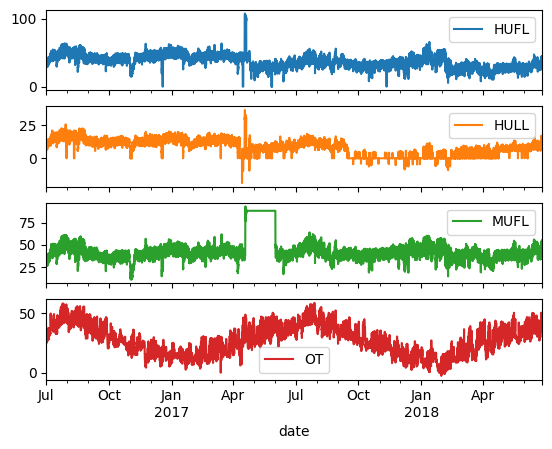

In [4]:
plot_cols = ['HUFL', 'HULL', 'MUFL', 'OT']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HUFL,17420.0,37.193346,10.218855,0.0000,30.156000,37.193001,44.062000,107.892998
HULL,17420.0,8.537565,6.020442,-18.6800,4.523000,9.131000,13.152000,36.438999
MUFL,17420.0,43.830356,13.056798,11.2050,37.394001,41.388000,46.078999,93.230003
MULL,17420.0,8.322694,4.366059,-6.5940,5.683000,9.302000,11.258000,28.736000
LUFL,17420.0,-3.423605,6.144403,-14.3500,-9.254000,-3.774000,2.527000,17.218000
LULL,17420.0,-2.085969,6.012796,-31.4620,-2.505000,-1.226000,0.000000,2.932000
OT,17420.0,26.609376,11.888266,-2.6465,16.469500,26.577000,35.585999,58.876999


In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.9)]
val_df = df[int(n*0.9):]

num_features = df.shape[1]

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

In [8]:
train_df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,0.295373,0.616868,-0.567230,0.249512,1.188835,0.539492,1.059389
1,-0.056950,0.244388,-0.758545,-0.151082,1.190700,0.524334,0.932313
2,-0.015966,0.430708,-0.655971,0.173041,0.794729,0.332483,0.877863
3,0.082336,0.523788,-0.640224,0.267311,1.011792,0.524334,0.641846
4,0.000369,0.457234,-0.650084,0.308403,0.783876,0.332483,0.496592
...,...,...,...,...,...,...,...
15673,-1.916863,-0.713577,-1.105708,-0.545742,-1.288062,0.078261,-0.649163
15674,-1.998831,-1.365616,-1.151035,-0.616280,-1.217516,0.068155,-0.667299
15675,-2.039814,-1.365616,-1.275316,-0.710550,-1.183091,0.068155,-0.703654
15676,-2.015165,-1.365616,-1.249709,-0.792954,-1.186822,0.068155,-0.721790


In [9]:
train_df.to_csv(processed_pretraining_data_paths[dataset]["train"], index=False)
val_df.to_csv(processed_pretraining_data_paths[dataset]["eval"], index=False)

In [11]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [12]:
BATCH_SIZE = 64
window_length = 10
shift = 1

feature_columns = df.columns
# feature_columns = ["OT"]

train_dataset = TimeSeriesDataset(
    train_df,
    metrics=["OT"],
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)
val_dataset = TimeSeriesDataset(
    val_df,
    metrics=["OT"],
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [14]:
for i, sample in enumerate(train_dataloader):
    if i == 0:
        print(i, sample["window"].shape, sample["target"].shape)
        break

0 torch.Size([64, 10, 7]) torch.Size([64, 1])


In [15]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [16]:
n_features = len(feature_columns)
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [17]:
model.eval()
mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        print("Loss:", loss.item())

        if i == 0:
            break

torch.Size([64, 10, 7]) torch.Size([64, 10]) torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1])
Loss: 0.4865954518318176


In [18]:
learning_rate = 1e-4
num_epochs = 20

In [19]:
train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [21]:
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    if early_stopper.early_stop(eval_loss):
        print(f"Early stopping at epoch {epoch}")
        break


progress_bar.close()

 70%|███████   | 3430/4900 [05:02<02:09, 11.35it/s]

Early stopping at epoch 13


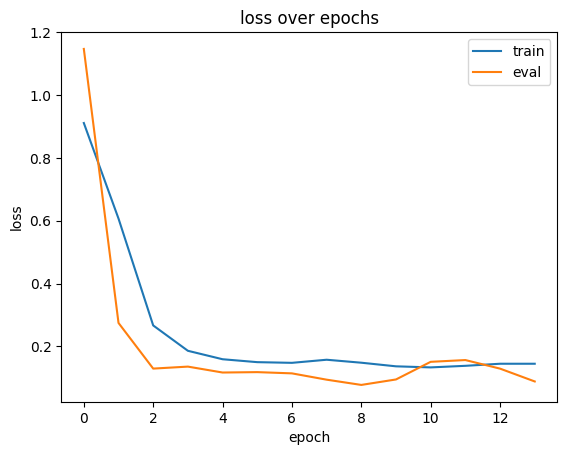

In [22]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

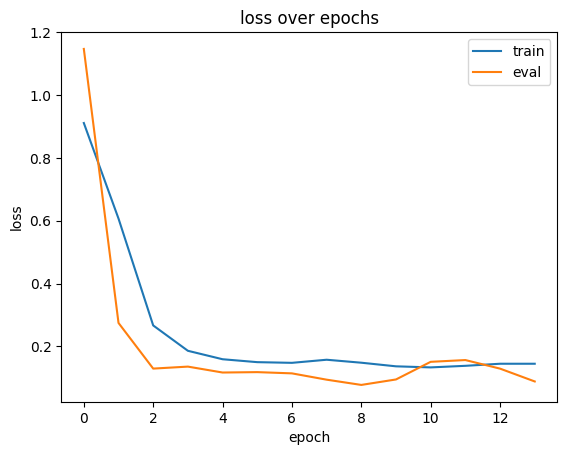

In [23]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

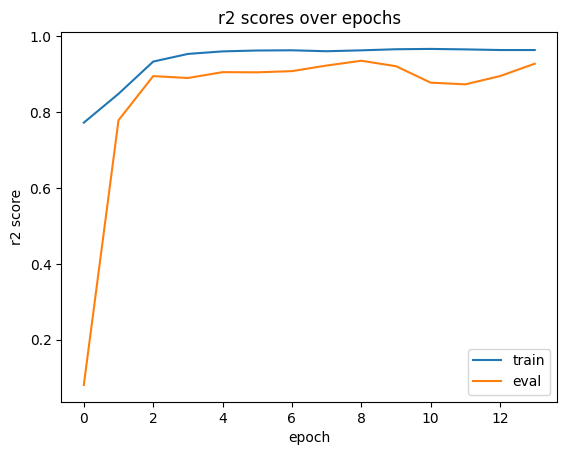

In [24]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()